In [25]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy

import pandas as pd
import zipfile
import urllib.request
import os
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [26]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
        

In [0]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x

In [0]:
class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())
        
        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu()

In [167]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

print(x_train.shape, y_train.shape)
num_epochs, batch_size = 2000, len(x_train)

net = MC_Dropout_Wrapper(network=MC_Dropout_Model(input_dim=1, output_dim=1, num_units=200, drop_prob=0.5),
                         learn_rate=1e-4, batch_size=batch_size, weight_decay=1e-2)

fit_loss_train = np.zeros(num_epochs)
best_net, best_loss = None, float('inf')
nets, losses = [], []

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %7.3f' % (i, loss.cpu().data.numpy()/batch_size))

(250, 1) (250, 1)
Epoch:    0, Train loss =   2.718
Epoch:  200, Train loss =   1.177
Epoch:  400, Train loss =   1.448
Epoch:  600, Train loss =   1.698
Epoch:  800, Train loss =   1.527
Epoch: 1000, Train loss =   1.614
Epoch: 1200, Train loss =   1.085
Epoch: 1400, Train loss =   1.118
Epoch: 1600, Train loss =   0.952
Epoch: 1800, Train loss =   0.893


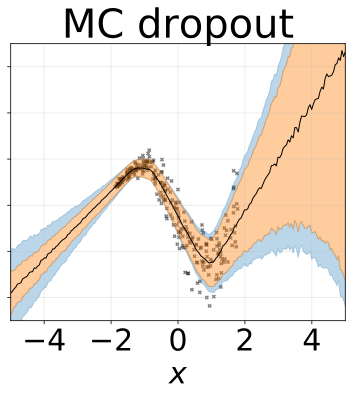

In [168]:
samples = []
noises = []
for i in range(1000):
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
noises = np.array(noises)
means = (samples.mean(axis = 0)).reshape(-1)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('MC dropout', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('mc_dropout_hetero.pdf', bbox_inches = 'tight')

files.download("mc_dropout_hetero.pdf")

plt.show()

# UCI datasets

In [0]:
class MC_Dropout_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model_UCI, self).__init__()
        

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer3(x)
        
        return x


def train_mc_dropout(data, drop_prob, n_splits, num_epochs, num_units, learn_rate, weight_decay, log_every, num_samples):
    
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    for j, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % j)
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test = (x_test - x_means)/x_stds
        y_test = (y_test - y_means)/y_stds

        net = MC_Dropout_Wrapper(network=MC_Dropout_Model_UCI(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
                                 learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

        losses = []
        fit_loss_train = np.zeros(num_epochs)

        for i in range(num_epochs):
            loss = net.fit(x_train, y_train)
                
            if i % log_every == 0 or i == num_epochs - 1:
                test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
                test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

                print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f Num. networks: %2d' %
                      (i, loss.cpu().data.numpy()/len(x_train), test_loss/len(x_test), rmse*y_stds[0], len(nets)))


        train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        
        train_logliks.append((train_loss.cpu().data.numpy()/len(x_train) + np.log(y_stds)[0]))
        test_logliks.append((test_loss.cpu().data.numpy()/len(x_test) + np.log(y_stds)[0]))

        train_rmses.append(y_stds[0]*train_rmse.cpu().data.numpy())
        test_rmses.append(y_stds[0]*test_rmse.cpu().data.numpy())


    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
    return net

# Housing dataset

In [171]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 21:59:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data.26’

housing.data.26     100%[===================>]  47.93K   170KB/s    in 0.3s    

2019-05-17 21:59:15 (170 KB/s) - ‘housing.data.26’ saved [49082/49082]



In [172]:
net = train_mc_dropout(data=data, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data)**0.5, num_samples=20, log_every=50)

FOLD 0:
Epoch:    0, Train loss:  1.535 Test loss:  1.451 RMSE: 9.593 Num. networks:  0
Epoch:   50, Train loss:  0.481 Test loss:  0.368 RMSE: 3.515 Num. networks:  0
Epoch:   99, Train loss:  0.445 Test loss:  0.721 RMSE: 4.615 Num. networks:  0
FOLD 1:
Epoch:    0, Train loss:  1.403 Test loss:  1.361 RMSE: 9.007 Num. networks:  0
Epoch:   50, Train loss:  0.960 Test loss:  0.587 RMSE: 4.070 Num. networks:  0
Epoch:   99, Train loss:  0.335 Test loss:  0.372 RMSE: 3.712 Num. networks:  0
FOLD 2:
Epoch:    0, Train loss:  1.425 Test loss:  1.273 RMSE: 7.422 Num. networks:  0
Epoch:   50, Train loss:  0.721 Test loss:  0.813 RMSE: 5.455 Num. networks:  0
Epoch:   99, Train loss:  0.677 Test loss:  0.445 RMSE: 4.838 Num. networks:  0
FOLD 3:
Epoch:    0, Train loss:  1.477 Test loss:  1.461 RMSE: 9.743 Num. networks:  0
Epoch:   50, Train loss:  0.600 Test loss:  0.714 RMSE: 5.968 Num. networks:  0
Epoch:   99, Train loss:  0.313 Test loss:  0.476 RMSE: 5.172 Num. networks:  0
FOLD 4:


# Concrete compressive dataset

In [173]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 21:59:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘Concrete_Data.xls.2’

Concrete_Data.xls.2 100%[===================>] 122.00K   289KB/s    in 0.4s    

2019-05-17 21:59:34 (289 KB/s) - ‘Concrete_Data.xls.2’ saved [124928/124928]



In [175]:
net = train_mc_dropout(data=data, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data)**0.5, num_samples=20, log_every=50)

FOLD 0:
Epoch:    0, Train loss:  1.468 Test loss:  1.376 RMSE: 16.071 Num. networks:  0
Epoch:   50, Train loss:  0.864 Test loss:  0.806 RMSE: 9.221 Num. networks:  0
Epoch:   99, Train loss:  0.597 Test loss:  0.588 RMSE: 7.697 Num. networks:  0
FOLD 1:
Epoch:    0, Train loss:  1.471 Test loss:  1.399 RMSE: 16.312 Num. networks:  0
Epoch:   50, Train loss:  1.009 Test loss:  0.785 RMSE: 9.052 Num. networks:  0
Epoch:   99, Train loss:  0.822 Test loss:  0.675 RMSE: 7.483 Num. networks:  0
FOLD 2:
Epoch:    0, Train loss:  1.451 Test loss:  1.346 RMSE: 15.448 Num. networks:  0
Epoch:   50, Train loss:  1.265 Test loss:  0.898 RMSE: 8.887 Num. networks:  0
Epoch:   99, Train loss:  0.869 Test loss:  1.291 RMSE: 12.942 Num. networks:  0
FOLD 3:
Epoch:    0, Train loss:  1.427 Test loss:  1.362 RMSE: 15.981 Num. networks:  0
Epoch:   50, Train loss:  0.769 Test loss:  0.923 RMSE: 9.978 Num. networks:  0
Epoch:   99, Train loss:  0.978 Test loss:  0.778 RMSE: 8.172 Num. networks:  0
FOL

# Energy efficiency dataset

In [176]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 22:00:09--  http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76189 (74K) [application/x-httpd-php]
Saving to: ‘ENB2012_data.xlsx’

ENB2012_data.xlsx   100%[===================>]  74.40K   233KB/s    in 0.3s    

2019-05-17 22:00:09 (233 KB/s) - ‘ENB2012_data.xlsx’ saved [76189/76189]



In [177]:
net = train_mc_dropout(data=data, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data)**0.5, num_samples=20, log_every=50)

FOLD 0:
Epoch:    0, Train loss:  1.465 Test loss:  1.453 RMSE: 9.908 Num. networks:  0
Epoch:   50, Train loss:  0.692 Test loss:  0.624 RMSE: 4.235 Num. networks:  0
Epoch:   99, Train loss:  0.289 Test loss:  0.278 RMSE: 2.754 Num. networks:  0
FOLD 1:
Epoch:    0, Train loss:  1.439 Test loss:  1.363 RMSE: 8.943 Num. networks:  0
Epoch:   50, Train loss:  0.939 Test loss:  0.851 RMSE: 6.823 Num. networks:  0
Epoch:   99, Train loss:  0.230 Test loss:  0.222 RMSE: 3.023 Num. networks:  0
FOLD 2:
Epoch:    0, Train loss:  1.391 Test loss:  1.261 RMSE: 8.080 Num. networks:  0
Epoch:   50, Train loss:  0.864 Test loss:  0.773 RMSE: 4.657 Num. networks:  0
Epoch:   99, Train loss:  0.744 Test loss:  0.639 RMSE: 3.888 Num. networks:  0
FOLD 3:
Epoch:    0, Train loss:  1.571 Test loss:  1.252 RMSE: 7.858 Num. networks:  0
Epoch:   50, Train loss:  0.545 Test loss:  0.363 RMSE: 2.623 Num. networks:  0
Epoch:   99, Train loss:  2.039 Test loss:  1.958 RMSE: 16.337 Num. networks:  0
FOLD 4:

# Power dataset

In [178]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip" --no-check-certificate 
zipped = zipfile.ZipFile("CCPP.zip")
data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
np.random.shuffle(data)
print(data.shape, data[:, -1].var()**0.5)

--2019-05-17 22:00:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  3.13MB/s    in 1.1s    

2019-05-17 22:00:32 (3.13 MB/s) - ‘CCPP.zip’ saved [3674852/3674852]

(9568, 5) 17.0661030975792


In [187]:
net = train_mc_dropout(data=data, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data)**0.5, num_samples=20, log_every=50)

FOLD 0:
Epoch:    0, Train loss:  1.412 Test loss:  1.155 RMSE: 10.069 Num. networks:  0
Epoch:   50, Train loss:  0.430 Test loss:  0.093 RMSE: 4.290 Num. networks:  0
Epoch:   99, Train loss:  0.247 Test loss: -0.070 RMSE: 3.281 Num. networks:  0
FOLD 1:
Epoch:    0, Train loss:  1.455 Test loss:  1.444 RMSE: 15.782 Num. networks:  0
Epoch:   50, Train loss:  0.661 Test loss:  0.719 RMSE: 12.197 Num. networks:  0
Epoch:   99, Train loss:  0.285 Test loss:  0.351 RMSE: 8.658 Num. networks:  0
FOLD 2:
Epoch:    0, Train loss:  1.442 Test loss:  1.349 RMSE: 13.963 Num. networks:  0
Epoch:   50, Train loss:  0.711 Test loss:  0.526 RMSE: 9.337 Num. networks:  0
Epoch:   99, Train loss:  0.590 Test loss:  0.452 RMSE: 7.253 Num. networks:  0
FOLD 3:
Epoch:    0, Train loss:  1.443 Test loss:  1.463 RMSE: 15.229 Num. networks:  0
Epoch:   50, Train loss:  0.703 Test loss:  0.904 RMSE: 11.284 Num. networks:  0
Epoch:   99, Train loss:  0.349 Test loss:  0.381 RMSE: 8.684 Num. networks:  0
FO

# Red wine dataset

In [188]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data = data[np.random.permutation(np.arange(len(data)))]
print(data.shape, data[:, -1].var()**0.5)

--2019-05-17 22:02:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv.1’

winequality-red.csv 100%[===================>]  82.23K   292KB/s    in 0.3s    

2019-05-17 22:02:06 (292 KB/s) - ‘winequality-red.csv.1’ saved [84199/84199]

(1598, 12) 0.8074125941863847


In [189]:
net = train_mc_dropout(data=data, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data)**0.5, num_samples=20, log_every=50)

FOLD 0:
Epoch:    0, Train loss:  1.430 Test loss:  1.465 RMSE: 0.840 Num. networks:  0
Epoch:   50, Train loss:  1.125 Test loss:  1.242 RMSE: 0.687 Num. networks:  0
Epoch:   99, Train loss:  1.079 Test loss:  1.233 RMSE: 0.682 Num. networks:  0
FOLD 1:
Epoch:    0, Train loss:  1.430 Test loss:  1.316 RMSE: 0.725 Num. networks:  0
Epoch:   50, Train loss:  1.140 Test loss:  1.015 RMSE: 0.568 Num. networks:  0
Epoch:   99, Train loss:  1.098 Test loss:  0.997 RMSE: 0.566 Num. networks:  0
FOLD 2:
Epoch:    0, Train loss:  1.461 Test loss:  1.486 RMSE: 0.870 Num. networks:  0
Epoch:   50, Train loss:  1.129 Test loss:  1.235 RMSE: 0.689 Num. networks:  0
Epoch:   99, Train loss:  1.088 Test loss:  1.227 RMSE: 0.680 Num. networks:  0
FOLD 3:
Epoch:    0, Train loss:  1.418 Test loss:  1.452 RMSE: 0.834 Num. networks:  0
Epoch:   50, Train loss:  1.116 Test loss:  1.279 RMSE: 0.734 Num. networks:  0
Epoch:   99, Train loss:  1.087 Test loss:  1.278 RMSE: 0.751 Num. networks:  0
FOLD 4:


# Yacht dataset

In [190]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
print(data.shape, data[:, -1].var()**0.5)

--2019-05-17 22:02:31--  http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11487 (11K) [application/x-httpd-php]
Saving to: ‘yacht_hydrodynamics.data.1’

yacht_hydrodynamics 100%[===================>]  11.22K  --.-KB/s    in 0s      

2019-05-17 22:02:31 (260 MB/s) - ‘yacht_hydrodynamics.data.1’ saved [11487/11487]

(306, 7) 15.162218637631366


In [191]:
net = train_mc_dropout(data=data, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data)**0.5, num_samples=20, log_every=50)

FOLD 0:
Epoch:    0, Train loss:  1.475 Test loss:  1.046 RMSE: 9.288 Num. networks:  0
Epoch:   50, Train loss:  0.551 Test loss:  0.215 RMSE: 3.851 Num. networks:  0
Epoch:   99, Train loss:  1.037 Test loss:  0.893 RMSE: 7.884 Num. networks:  0
FOLD 1:
Epoch:    0, Train loss:  1.446 Test loss:  1.476 RMSE: 16.252 Num. networks:  0
Epoch:   50, Train loss:  0.596 Test loss:  0.712 RMSE: 12.201 Num. networks:  0
Epoch:   99, Train loss:  0.083 Test loss:  0.863 RMSE: 8.545 Num. networks:  0
FOLD 2:
Epoch:    0, Train loss:  1.522 Test loss:  1.389 RMSE: 14.620 Num. networks:  0
Epoch:   50, Train loss:  1.655 Test loss:  1.309 RMSE: 12.128 Num. networks:  0
Epoch:   99, Train loss:  0.858 Test loss:  0.770 RMSE: 7.683 Num. networks:  0
FOLD 3:
Epoch:    0, Train loss:  1.395 Test loss:  1.404 RMSE: 14.795 Num. networks:  0
Epoch:   50, Train loss:  0.876 Test loss:  0.884 RMSE: 11.261 Num. networks:  0
Epoch:   99, Train loss: -0.066 Test loss: -0.073 RMSE: 6.413 Num. networks:  0
FO